# Prepare training data

In [1]:
with open('dino_names_scraped_from_wikipedia.txt') as f:
    dinos = [d + '\n' for d in f.read().split()] # adding newline as stop character

## Tokenize

In [2]:
from functools import reduce
vocab = sorted(reduce(
    lambda x,y: x.union(y),
    [set(d) for d in dinos]))

In [3]:
print(vocab)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
token_to_index = {v:k for k,v in enumerate(vocab)}
index_to_token = {k:v for k,v in enumerate(vocab)}

In [5]:
dinos_tokenized = [[token_to_index[letter] for letter in dino] for dino in dinos]

In [6]:
dinos_tokenized[:5]

[[1, 1, 3, 8, 5, 14, 15, 19, 1, 21, 18, 21, 19, 0],
 [1, 1, 18, 4, 15, 14, 25, 24, 0],
 [1, 2, 4, 1, 12, 12, 1, 8, 19, 1, 21, 18, 21, 19, 0],
 [1, 2, 4, 1, 18, 1, 9, 14, 21, 18, 21, 19, 0],
 [1, 2, 4, 9, 20, 15, 19, 1, 21, 18, 21, 19, 0]]

In [7]:
dinos[:5]

['aachenosaurus\n',
 'aardonyx\n',
 'abdallahsaurus\n',
 'abdarainurus\n',
 'abditosaurus\n']

# Define model

In [8]:
# adapted from
# https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html?highlight=rnn
# with insights from
# https://towardsdatascience.com/character-level-language-model-1439f5dd87fe

import torch
import torch.nn as nn
import numpy as np

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(len(vocab), hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        # note we are going to output logits and use CrossEntropyLoss,
        # so no need to define softmax here
    
    def forward(self, input, hidden):
        # input is a single one-hot encoded token, in the form of a 2d
        # array with first dimension 1 and second dimension the vocab size
        hidden, _ = self.rnn(input, hidden) # the two outputs are equal the way we have things set up; not sure of different in general though
        x = self.dropout(hidden)
        x = self.linear1(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        return logits, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
        
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(dino):
    # we make a 2x2 array where each row is the 1-hot encoding for
    # each letter, ordered from top to bottom, then expand into 
    # the shape (name length, 1, vocab size) that pytorch is expecting
    # note we are not including the stop character
    onehot = np.zeros((len(dino)-1, len(vocab)))
    for row, letter in enumerate(dino[:-1]):
        col = token_to_index[letter]
        onehot[row, col] = 1
    return torch.from_numpy(np.expand_dims(onehot, axis=1)).float() # numpy default is float64 but torch wants float32

# LongTensor of second letter to end (EOS) for target
def targetTensor(dino):
    # a 1-d tensor containing the class index of the next letter
    return torch.LongTensor([token_to_index[letter] for letter in dino[1:]])

# Train model

In [9]:
def training_loop_for_one_example(input_tensor, output_tensor):
    
    # initialize
    hidden = rnn.initHidden()
    opt.zero_grad()
    example_loss = 0
    
    # loop through all letters, trying to predict next letter and summing losses
    for ii in range(len(input_tensor)):
        logits, hidden = rnn(input_tensor[[ii]], hidden)
        letter_loss = lossfun(logits[0], target_tensor[[ii]])
        example_loss += letter_loss
        
    # use loss on this training example to update parameters
    example_loss.backward()
    opt.step()
    
    # return loss so we can plot it
    return example_loss.item()/len(input_tensor) # average over letter loss

In [10]:
# define model and some other tools
rnn = RNN(len(vocab), 128, len(vocab))
lossfun = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(rnn.parameters())

# now loop over the examples

import random
import datetime

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

for iter in range(n_iters):
    random_dino = random.choice(dinos)
    input_tensor = inputTensor(random_dino)
    target_tensor = targetTensor(random_dino)
    
    try:
        example_loss = training_loop_for_one_example(input_tensor, target_tensor)
    except:
        print(f'{iter} {random_dino}')
        print(f'input tensor shape: {input_tensor.shape}')
        print(f'target tensor shape: {target_tensor.shape}')
        
    total_loss += example_loss

    if iter % print_every == 0:
        print(f'{datetime.datetime.now()} on {iter}/{n_iters}, loss: {example_loss}')

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

2022-03-27 17:42:43.069177 on 0/100000, loss: 3.2864879608154296
2022-03-27 17:43:30.187142 on 5000/100000, loss: 3.3059139251708984
2022-03-27 17:44:15.394189 on 10000/100000, loss: 2.0185726483662925
2022-03-27 17:44:57.771506 on 15000/100000, loss: 2.4566009521484373
2022-03-27 17:45:53.699294 on 20000/100000, loss: 2.794039249420166
2022-03-27 17:46:39.495733 on 25000/100000, loss: 2.542125701904297
2022-03-27 17:47:21.043097 on 30000/100000, loss: 4.736359066433376
2022-03-27 17:48:06.177749 on 35000/100000, loss: 2.714818000793457
2022-03-27 17:48:47.936303 on 40000/100000, loss: 1.4670014699300131
2022-03-27 17:49:28.661677 on 45000/100000, loss: 3.0968720572335378
2022-03-27 17:50:09.837284 on 50000/100000, loss: 1.9818528493245442
2022-03-27 17:50:56.309785 on 55000/100000, loss: 2.347428798675537
2022-03-27 17:51:42.485799 on 60000/100000, loss: 2.3667417006059126
2022-03-27 17:52:38.623271 on 65000/100000, loss: 1.4492762565612793
2022-03-27 17:53:46.861274 on 70000/100000, 

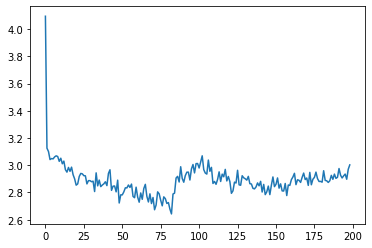

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses[1:])

The above is not as small a loss as I was getting with the architecture specified in the pytorch tutorial. And it looks like it started overfitting around halfway through training. Also not sure why it starts tiny and jumps up. That's why I graphed only from element 1 onward.

Needs improvement but saving what I have for now.

In [13]:
torch.save(rnn, 'dino_rnn.pth')

# Generate

Now generate some dino names to see what kind of results we get. The model I used above needs to be seeded with a first letter so first I have to figure out how to choose first letter.

In [21]:
import pandas as pd
first_letter_freq_dist = pd.Series(
    [d[0] for d in dinos]).value_counts()/len(dinos)
first_letter_freq_dist

a    0.108014
s    0.095238
p    0.077236
c    0.067944
t    0.062718
m    0.059233
l    0.052846
d    0.052265
b    0.049942
h    0.040070
g    0.038908
e    0.038328
n    0.034262
k    0.029617
o    0.027875
r    0.024971
i    0.019164
y    0.018002
j    0.016260
z    0.016260
v    0.015099
f    0.014518
u    0.011614
w    0.011614
x    0.011614
q    0.006388
dtype: float64

In [24]:
# save for inference later
first_letter_freq_dist.to_csv(
    'dino_first_letter_freq_dist.csv', header=False)

In [93]:
# will also need this
import json
with open('dino_model_vocab.json','w') as f:
    json.dump(vocab, f)

In [96]:
with open('dino_first_letter_freq_dist.csv') as f:
    first_letter, frequency = zip(*[
        line.split(',') for line in f.read().split()
    ])
frequency = [float(f) for f in frequency]

with open('dino_model_vocab.json') as f:
    vocab = json.load(f)
token_to_index = {v:k for k,v in enumerate(vocab)}
index_to_token = {k:v for k,v in enumerate(vocab)}

rnn = torch.load('dino_rnn.pth')

In [51]:
def letterTensor(letter):
    onehot = np.zeros((1, len(vocab)))
    index = token_to_index[letter]
    onehot[0, index] = 1
    return torch.from_numpy(np.expand_dims(onehot, axis=1)).float() # numpy default is float64 but torch wants float32

In [77]:
import random
def generate(maxlen=30):
    # first generate first letter
    x = random.choices(first_letter, weights=frequency, k=1)[0]
    with torch.no_grad():
        hidden = rnn.initHidden()
        generated = ''

        while x != '\n':
            # append this letter to the generated string
            generated += x
            # convert x to an input tensor
            letter_tensor = letterTensor(x)
            # generate logits and hidden
            logits, hidden = rnn(letter_tensor[[0]], hidden)
            # from the logits, compute probabilities
            probs = nn.Softmax(dim=2)(logits).flatten()
            # pull next letter from this probability distribution
            x = random.choices(vocab, weights=probs, k=1)[0]
    
    return generated

In [89]:
for _ in range(5):
    print(generate())

caosolaua
mak
trolepuinusxs
sakaoauinuras
rurionurenrenais


Wow that sucks so much. Needs improvement for sure! Will come back to this but I want to set up my widgets first...